# Training a deep neural network on EMNIST Letters

This notebook demonstrates:
1. Loading and preprocessing EMNIST Letters dataset
2. Building and training a neural network similar to the MNIST example
3. Using KerasTune for hyperparameter optimization
4. Enhanced Tensorboard visualization

In [ ]:
pip install -q -U keras-tuner

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 4.4 MB/s eta 0:00:00


In [ ]:
# TensorFlow and tf.keras
import tensorflow as tf
import tensorflow_datasets as tfds
import os

# Helper libraries
import numpy as np
import matplotlib.pyplot as plt
import keras_tuner as kt

print(tf.__version__)
print(tf.config.list_physical_devices())

2.18.0
[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


## Setup Tensorboard logging

We'll create a more organized logging structure for Tensorboard with multiple metrics and visualizations.

In [ ]:
# Setup folder for tensorboard logs
root_logdir = os.path.join(os.curdir, "my_logs_ML2")

def get_run_logdir():
    import time
    run_id = time.strftime("run_%Y_%m_%d-%H_%M_%S")
    return os.path.join(root_logdir, run_id)

run_logdir = get_run_logdir()

# Create tensorboard callback with more metrics
tensorboard_cb = tf.keras.callbacks.TensorBoard(
    log_dir=run_logdir,
    histogram_freq=1,  # Log histogram of weights
    write_graph=True,  # Log model graph
    write_images=True,  # Log model weights as images
    update_freq='epoch',  # Update at the end of each epoch
    profile_batch='500,520'  # Profile performance for batches 500-520
)

## Load and preprocess EMNIST Letters dataset

In [ ]:
# Load EMNIST Letters dataset
(ds_train, ds_test), ds_info = tfds.load(
    'emnist/letters',  # Using letters variant
    split=['train', 'test'],
    shuffle_files=True,
    as_supervised=True,
    with_info=True,
)

# Convert to numpy arrays
def prepare_dataset(dataset):
    images = []
    labels = []
    for image, label in dataset:
        # Labels in EMNIST are 1-indexed (1-26), subtract 1 to make 0-indexed
        images.append(image.numpy())
        labels.append(label.numpy() - 1)  # Convert to 0-25 range

    return np.array(images), np.array(labels)

# Get training and test data
train_images, train_labels = prepare_dataset(ds_train)
test_images, test_labels = prepare_dataset(ds_test)

# Normalize pixel values to be between 0 and 1
train_images = train_images / 255.0
test_images = test_images / 255.0

# Create a letter map for easier visualization (A-Z)
letters = [chr(ord('A') + i) for i in range(26)]

print('Training set shape:', train_images.shape)
print('Test set shape:', test_images.shape)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/emnist/letters/incomplete.N2W32H_3.1.0/emnist-train.tfrecord*...:   0%|   …

Generating test examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/emnist/letters/incomplete.N2W32H_3.1.0/emnist-test.tfrecord*...:   0%|    …

Dataset emnist downloaded and prepared to /root/tensorflow_datasets/emnist/letters/3.1.0. Subsequent calls will reuse this data.
Training set shape: (88800, 28, 28, 1)
Test set shape: (14800, 28, 28, 1)


## Explore the data

In [ ]:
# Display information about the dataset
print(f"Number of training examples: {len(train_images)}")
print(f"Number of test examples: {len(test_images)}")
print(f"Image shape: {train_images[0].shape}")
print(f"Number of classes: {len(np.unique(train_labels))}")

Number of training examples: 88800
Number of test examples: 14800
Image shape: (28, 28, 1)
Number of classes: 26


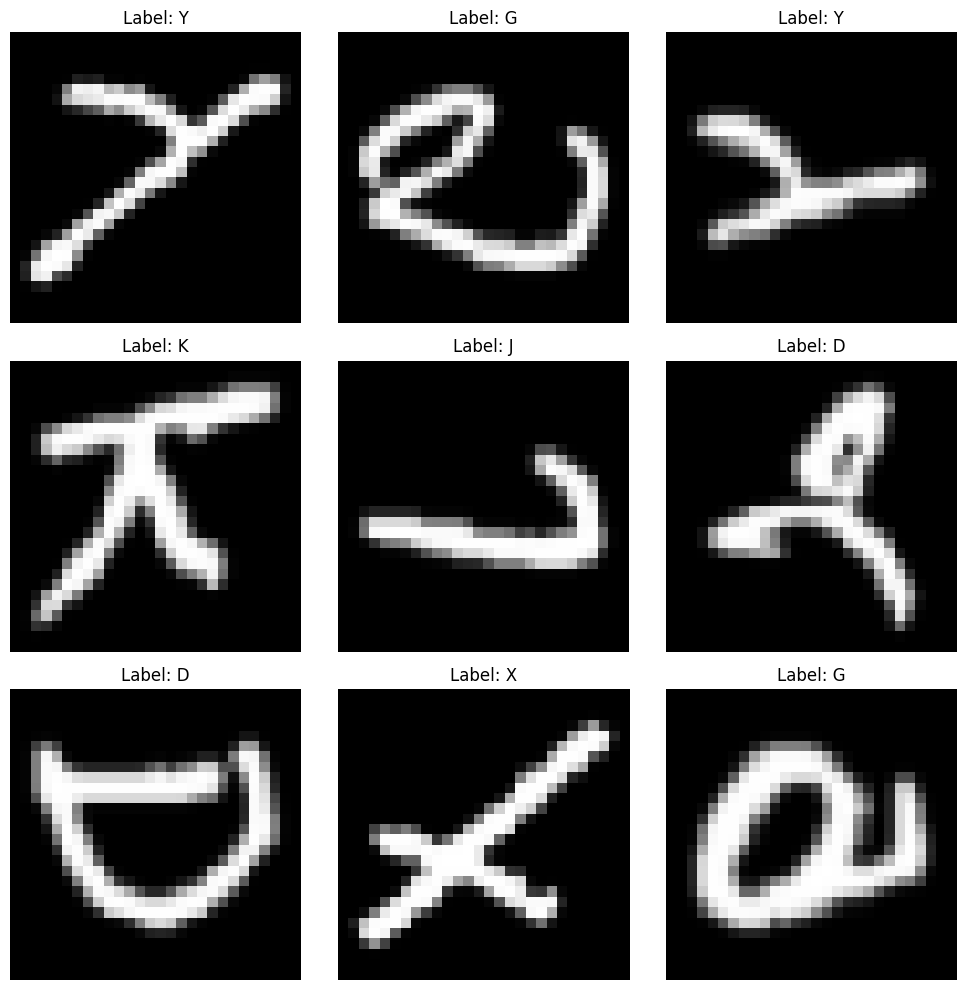

In [ ]:
# Display first 9 images from the training set
plt.figure(figsize=(10, 10))
for i in range(9):
    plt.subplot(3, 3, i + 1)
    plt.imshow(train_images[i], cmap='gray')
    plt.title(f'Label: {letters[train_labels[i]]}')
    plt.axis('off')
plt.tight_layout()
plt.show()

## Define the model architecture with KerasTune

We'll keep a similar architecture to the original MNIST example, but use KerasTune to find optimal hyperparameters.

In [ ]:
def build_model(hp):
    model = tf.keras.Sequential([
        # Flatten the input images
        tf.keras.layers.Flatten(input_shape=(28, 28, 1)),

        # First dense layer with tunable units (similar to original MNIST example)
        tf.keras.layers.Dense(
            units=hp.Int('dense_1_units', min_value=128, max_value=512, step=64),
            activation='relu',
            kernel_initializer=tf.keras.initializers.he_normal
        ),

        # Second dense layer with tunable units
        tf.keras.layers.Dense(
            units=hp.Int('dense_2_units', min_value=64, max_value=256, step=32),
            activation='relu',
            kernel_initializer=tf.keras.initializers.he_normal
        ),

        # Optional third dense layer
        tf.keras.layers.Dense(
            units=hp.Int('dense_3_units', min_value=32, max_value=128, step=32),
            activation='relu',
            kernel_regularizer=tf.keras.regularizers.L2(
                hp.Float('l2_reg', min_value=0.001, max_value=0.1, sampling='log')
            )
        ),

        # Dropout layer with tunable rate
        tf.keras.layers.Dropout(
            rate=hp.Float('dropout_rate', min_value=0.1, max_value=0.5, step=0.1)
        ),

        # Output layer - 26 classes (A-Z) with softmax activation
        tf.keras.layers.Dense(26, activation='softmax')
    ])

    # Compile with tunable learning rate
    model.compile(
        optimizer=tf.keras.optimizers.Adam(
            hp.Float('learning_rate', min_value=1e-3, max_value=1e-2, sampling='log')
        ),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )

    return model

## Setup KerasTune

In [ ]:
# Initialize the tuner
tuner = kt.Hyperband(
    build_model,
    objective='val_accuracy',
    max_epochs=10,
    directory='keras_tuner_dir',
    project_name='emnist_letters'
)

# Display search space summary
tuner.search_space_summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Search space summary
Default search space size: 6
dense_1_units (Int)
{'default': None, 'conditions': [], 'min_value': 128, 'max_value': 512, 'step': 64, 'sampling': 'linear'}
dense_2_units (Int)
{'default': None, 'conditions': [], 'min_value': 64, 'max_value': 256, 'step': 32, 'sampling': 'linear'}
dense_3_units (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 128, 'step': 32, 'sampling': 'linear'}
l2_reg (Float)
{'default': 0.001, 'conditions': [], 'min_value': 0.001, 'max_value': 0.1, 'step': None, 'sampling': 'log'}
dropout_rate (Float)
{'default': 0.1, 'conditions': [], 'min_value': 0.1, 'max_value': 0.5, 'step': 0.1, 'sampling': 'linear'}
learning_rate (Float)
{'default': 0.001, 'conditions': [], 'min_value': 0.001, 'max_value': 0.01, 'step': None, 'sampling': 'log'}


## Create a learning rate scheduler for better convergence

In [ ]:
def scheduler(epoch, lr):
    if epoch < 5:
        return lr
    else:
        return lr * 1/10. #tf.math.exp(-0.1)

lr_scheduler = tf.keras.callbacks.LearningRateScheduler(scheduler)

## Perform hyperparameter search

In [ ]:
# Define early stopping
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=3,
    restore_best_weights=True
)

# Add model checkpoint callback
checkpoint_cb = tf.keras.callbacks.ModelCheckpoint(
    filepath='best_model_checkpoint.keras',
    save_best_only=True,
    monitor='val_accuracy'
)

# Perform the search
tuner.search(
    train_images, train_labels,
    validation_split=0.1,
    epochs=10,
    callbacks=[tensorboard_cb, early_stopping, checkpoint_cb]
)

Trial 30 Complete [00h 01m 44s]
val_accuracy: 0.8838964104652405

Best val_accuracy So Far: 0.9041666388511658
Total elapsed time: 00h 23m 32s


## Get the best model

In [ ]:
# Get the best hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
print("Best hyperparameters:")
for param, value in best_hps.values.items():
    print(f"{param}: {value}")

# Build the best model
best_model = build_model(best_hps)
best_model.summary()

Best hyperparameters:
dense_1_units: 320
dense_2_units: 224
dense_3_units: 64
l2_reg: 0.09329249461505033
dropout_rate: 0.30000000000000004
learning_rate: 0.001121394332826012
tuner/epochs: 10
tuner/initial_epoch: 4
tuner/bracket: 2
tuner/round: 2
tuner/trial_id: 0015


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ flatten_1 (Flatten)                  │ (None, 784)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 320)                 │         251,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 224)                 │          71,904 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 64)                  │          14,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 26)                  │           1,690 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 339,194 (1.29 MB)

 Trainable params: 339,194 (1.29 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Train the best model for more epochs
history = best_model.fit(
    train_images, train_labels,
    epochs=15,
    validation_split=0.1,
    callbacks=[tensorboard_cb, early_stopping, checkpoint_cb, lr_scheduler]
)

Epoch 1/15
2498/2498 ━━━━━━━━━━━━━━━━━━━━ 13s 4ms/step - accuracy: 0.5843 - loss: 2.3695 - val_accuracy: 0.8312 - val_loss: 0.6842 - learning_rate: 0.0011
Epoch 2/15
2498/2498 ━━━━━━━━━━━━━━━━━━━━ 17s 3ms/step - accuracy: 0.8311 - loss: 0.7018 - val_accuracy: 0.8666 - val_loss: 0.5684 - learning_rate: 0.0011
Epoch 3/15
2498/2498 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - accuracy: 0.8670 - loss: 0.5646 - val_accuracy: 0.8783 - val_loss: 0.4955 - learning_rate: 0.0011
Epoch 4/15
2498/2498 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - accuracy: 0.8852 - loss: 0.4869 - val_accuracy: 0.8858 - val_loss: 0.4817 - learning_rate: 0.0011
Epoch 5/15
2498/2498 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - accuracy: 0.8964 - loss: 0.4418 - val_accuracy: 0.8839 - val_loss: 0.4907 - learning_rate: 0.0011
Epoch 6/15
2498/2498 ━━━━━━━━━━━━━━━━━━━━ 11s 4ms/step - accuracy: 0.9244 - loss: 0.3235 - val_accuracy: 0.9120 - val_loss: 0.3323 - learning_rate: 1.1214e-04
Epoch 7/15
2498/2498 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - accuracy: 0

## Evaluate the model

In [ ]:
# Evaluate on test set
test_loss, test_acc = best_model.evaluate(test_images, test_labels, verbose=2)
print(f'\nTest loss: {test_loss:.4f}')
print(f'Test accuracy: {test_acc:.4f}')

# Save the best model
best_model.save('best_emnist_letters_model.keras')

## Add weights and gradients to Tensorboard

In [ ]:
# Create a writer for the custom TensorBoard data
custom_writer = tf.summary.create_file_writer(os.path.join(run_logdir, 'custom_metrics'))

# Log sample images with predictions
with custom_writer.as_default():
    # Get sample images
    sample_images = test_images[:10]
    sample_labels = test_labels[:10]

    # Make predictions
    predictions = best_model.predict(sample_images)
    predicted_labels = np.argmax(predictions, axis=1)

    # Convert images to right format for TensorBoard (add batch dimension)
    images_for_tb = np.reshape(sample_images, (-1, 28, 28, 1))

    # Add titles with true and predicted labels
    titles = [f"True: {letters[true]}, Pred: {letters[pred]}"
              for true, pred in zip(sample_labels, predicted_labels)]

    # Log images with predictions as titles
    tf.summary.image('Test Predictions', images_for_tb, max_outputs=10, step=0)

## Visualize results

In [ ]:
# Plot training history
plt.figure(figsize=(10, 3))

# Plot accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='lower right')

# Plot loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.tight_layout()
plt.show()

## Make predictions and visualize results

In [ ]:
# Get some test samples
sample_indices = np.random.choice(len(test_images), 25, replace=False)
sample_images = test_images[sample_indices]
sample_labels = test_labels[sample_indices]

# Make predictions
predictions = best_model.predict(sample_images)
predicted_labels = np.argmax(predictions, axis=1)

# Visualize predictions
plt.figure(figsize=(15, 15))
for i in range(25):
    plt.subplot(5, 5, i + 1)
    plt.imshow(sample_images[i].squeeze(), cmap='gray')

    # Get confidence for the prediction
    confidence = predictions[i][predicted_labels[i]] * 100

    color = 'green' if predicted_labels[i] == sample_labels[i] else 'red'
    plt.title(f'True: {letters[sample_labels[i]]}\nPred: {letters[predicted_labels[i]]}\nConf: {confidence:.2f}%',
              color=color, fontsize=9)
    plt.axis('off')
plt.tight_layout()
plt.show()

## Confusion Matrix

463/463 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


<ipython-input-17-7c4f3fc30c4b>:13: RuntimeWarning: invalid value encountered in divide
  cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


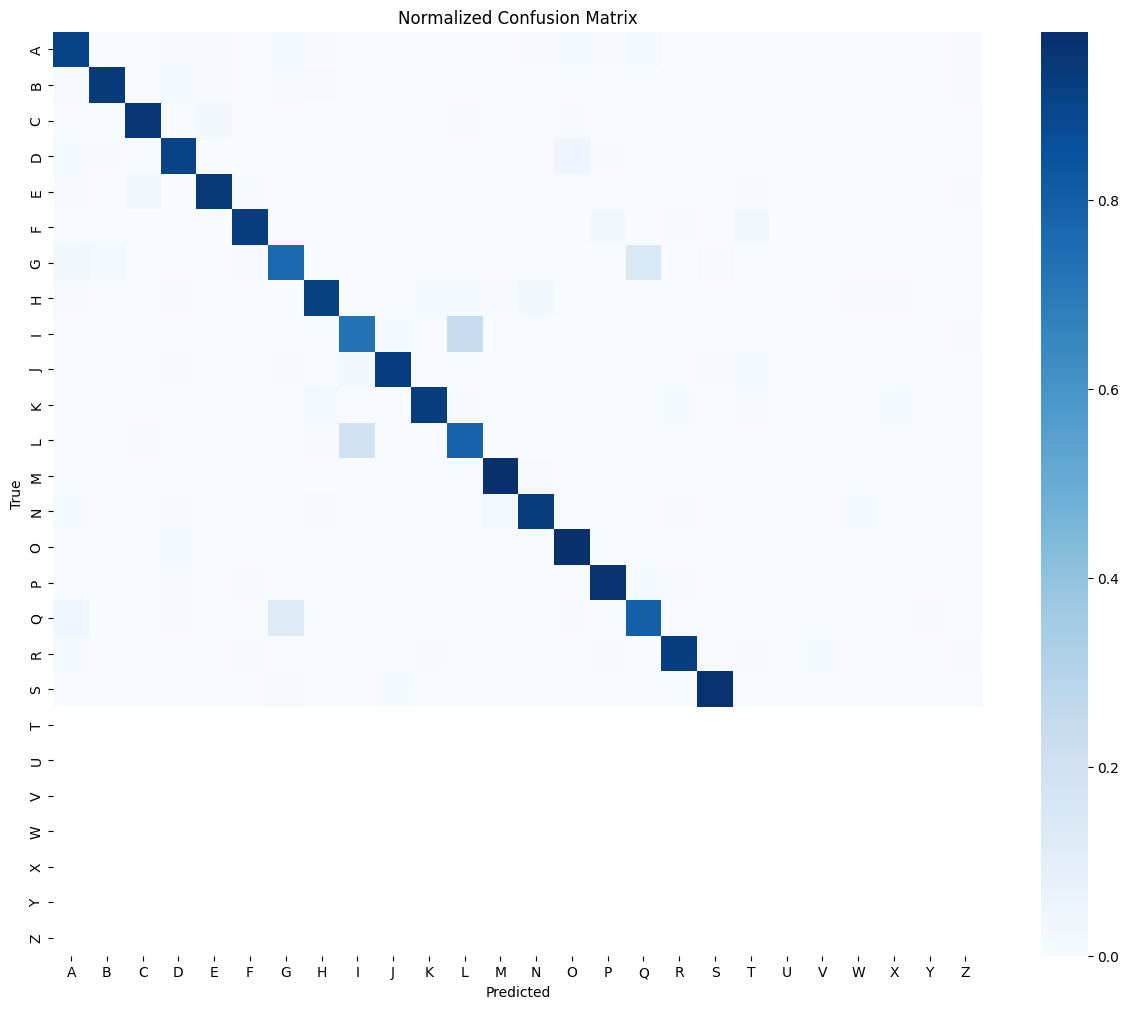

              precision    recall  f1-score   support

           A       0.89      0.91      0.90       800
           B       0.96      0.94      0.95       800
           C       0.96      0.95      0.95       800
           D       0.93      0.91      0.92       800
           E       0.96      0.94      0.95       800
           F       0.97      0.93      0.95       800
           G       0.82      0.77      0.79       800
           H       0.93      0.92      0.92       800
           I       0.76      0.72      0.74       800
           J       0.97      0.92      0.95       800
           K       0.97      0.93      0.95       800
           L       0.74      0.78      0.76       800
           M       0.97      0.97      0.97       800
           N       0.94      0.93      0.93       800
           O       0.93      0.98      0.95       800
           P       0.95      0.96      0.96       800
           Q       0.81      0.80      0.80       800
           R       0.95    

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [ ]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

# Make predictions on all test data
predictions = best_model.predict(test_images)
predicted_labels = np.argmax(predictions, axis=1)

# Calculate confusion matrix
cm = confusion_matrix(test_labels, predicted_labels)

# Plot confusion matrix - normalized version
plt.figure(figsize=(15, 12))
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
sns.heatmap(cm_normalized, annot=False, fmt='.2f', cmap='Blues',
            xticklabels=letters,
            yticklabels=letters)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Normalized Confusion Matrix')
plt.show()

# Print classification report
print(classification_report(test_labels, predicted_labels,
                           target_names=letters))

## Identify commonly confused letter pairs

In [ ]:
# Find the most commonly confused letter pairs
num_classes = len(letters)
confusion_pairs = []
for i in range(num_classes):
    for j in range(num_classes):
        if i != j:  # Skip the diagonal
            # How often class i is predicted as class j
            confusion_pairs.append({
                'true': letters[i],
                'predicted': letters[j],
                'count': cm[i, j],
                'rate': cm_normalized[i, j]
            })

# Sort by count (descending)
confusion_pairs = sorted(confusion_pairs, key=lambda x: x['count'], reverse=True)

# Display the top 10 most confused pairs
print("Top 10 most confused letter pairs:")
for i, pair in enumerate(confusion_pairs[:10]):
    print(f"{i+1}. True: {pair['true']}, Predicted: {pair['predicted']}, Count: {pair['count']}, Rate: {pair['rate']:.2f}")

Top 10 most confused letter pairs:
1. True: I, Predicted: L, Count: 192, Rate: 0.24
2. True: L, Predicted: I, Count: 151, Rate: 0.19
3. True: G, Predicted: Q, Count: 119, Rate: 0.15
4. True: Q, Predicted: G, Count: 100, Rate: 0.12
5. True: D, Predicted: O, Count: 37, Rate: 0.05
6. True: Q, Predicted: A, Count: 28, Rate: 0.04
7. True: J, Predicted: I, Count: 24, Rate: 0.03
8. True: G, Predicted: A, Count: 22, Rate: 0.03
9. True: F, Predicted: P, Count: 20, Rate: 0.03
10. True: F, Predicted: T, Count: 19, Rate: 0.02
